<a href="https://colab.research.google.com/github/SakshyamAryal077/RBCCLASSIFIER/blob/main/RBCCLASSIFIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Install Kaggle API

In [ ]:
!pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sakshyamaryal077","key":"31932307f5ea0239a92bb67ec7429d4e"}'}

*Upload*
 kaggle.json

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Download and Unzip Dataset


In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 660M/675M [00:02<00:00, 227MB/s]
100% 675M/675M [00:02<00:00, 324MB/s]


Verify Structure and Preview Samples

Base path exists: True
Parasitized: 13780 images
Uninfected: 13780 images
Sample from Parasitized:


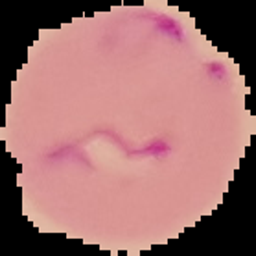

Sample from Uninfected:


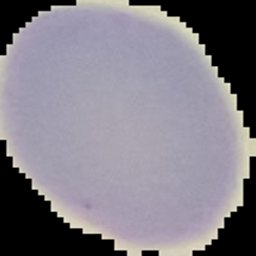

In [ ]:
import os, random
from PIL import Image
from IPython.display import display

if os.path.exists("/content/cell_images/cell_images/Parasitized"):
    base = "/content/cell_images/cell_images"
elif os.path.exists("/content/cell_images/Parasitized"):
    base = "/content/cell_images"
else:
    raise FileNotFoundError("Dataset not found! Please upload or extract correctly.")

print("Base path exists:", os.path.exists(base))

for sub in ["Parasitized", "Uninfected"]:
    folder = os.path.join(base, sub)
    print(f"{sub}: {len(os.listdir(folder))} images")

# Display random sample from each class
for sub in ["Parasitized", "Uninfected"]:
    folder = os.path.join(base, sub)
    img = Image.open(os.path.join(folder, random.choice(os.listdir(folder))))
    print(f"Sample from {sub}:")
    display(img.resize((256,256)))


Count & visualize data distribution

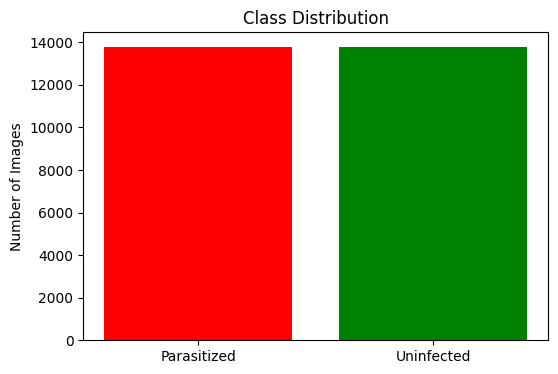

Parasitized: 13780
Uninfected: 13780


In [ ]:
import os
import matplotlib.pyplot as plt

base = "/content/cell_images/cell_images"

parasite_count = len(os.listdir(os.path.join(base, "Parasitized")))
uninfected_count = len(os.listdir(os.path.join(base, "Uninfected")))

# Bar chart
plt.figure(figsize=(6,4))
plt.bar(["Parasitized", "Uninfected"], [parasite_count, uninfected_count], color=["red","green"])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

print(f"Parasitized: {parasite_count}\nUninfected: {uninfected_count}")


Check Image Sizes.

In [ ]:
from PIL import Image
import numpy as np

sizes = []
for folder in ["Parasitized", "Uninfected"]:
    folder_path = os.path.join(base, folder)
    for img_file in os.listdir(folder_path)[:500]:  # sample 500 images for speed
        img = Image.open(os.path.join(folder_path, img_file))
        sizes.append(img.size)

sizes = np.array(sizes)
print("Average size (width x height):", sizes.mean(axis=0))
print("Unique sizes found:", len(np.unique(sizes, axis=0)))


Average size (width x height): [132.148 132.385]
Unique sizes found: 440


Sample visualization grid

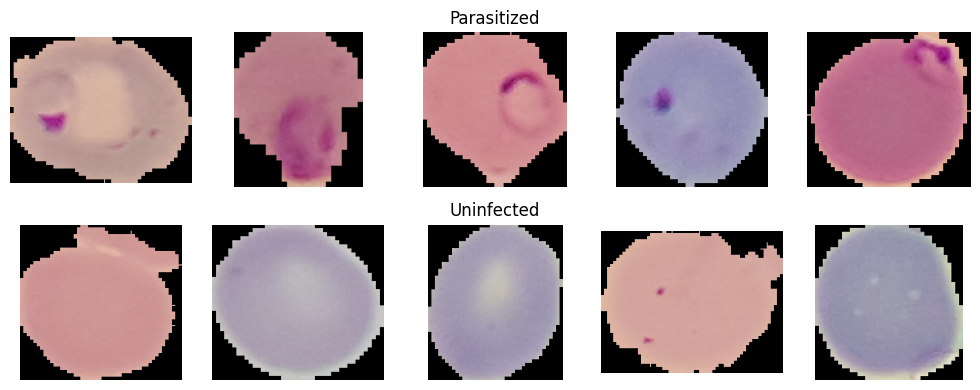

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10,4))
classes = ["Parasitized", "Uninfected"]

for i, cls in enumerate(classes):
    folder = os.path.join(base, cls)
    imgs = random.sample(os.listdir(folder), 5)
    for j, img_name in enumerate(imgs):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 2:
            axes[i, j].set_title(cls)

plt.tight_layout()
plt.show()


Load & Split Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define base directory
base = "/content/cell_images/cell_images"

# Create train-validation-test split generators
datagen = ImageDataGenerator(
    rescale=1./255,            # normalize pixels
    validation_split=0.2       # 80% train, 20% validation
)

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    base,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


Visualize an Augmented Batch

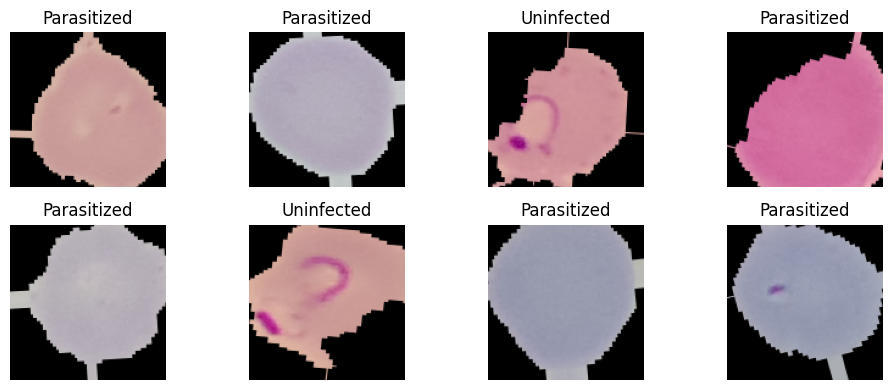

In [ ]:
import matplotlib.pyplot as plt
images, labels = next(train_generator)

plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.title("Parasitized" if labels[i]==1 else "Uninfected")
    plt.axis('off')
plt.tight_layout()
plt.show()


Build the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Build the CNN
model = Sequential([
    # Layer 1 - basic feature extraction
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Layer 2 - deeper features
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Layer 3 - more abstract patterns
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Flatten for classification
    Flatten(),

    # Dense layers - decision making
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # binary output
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Save Architecture Diagram

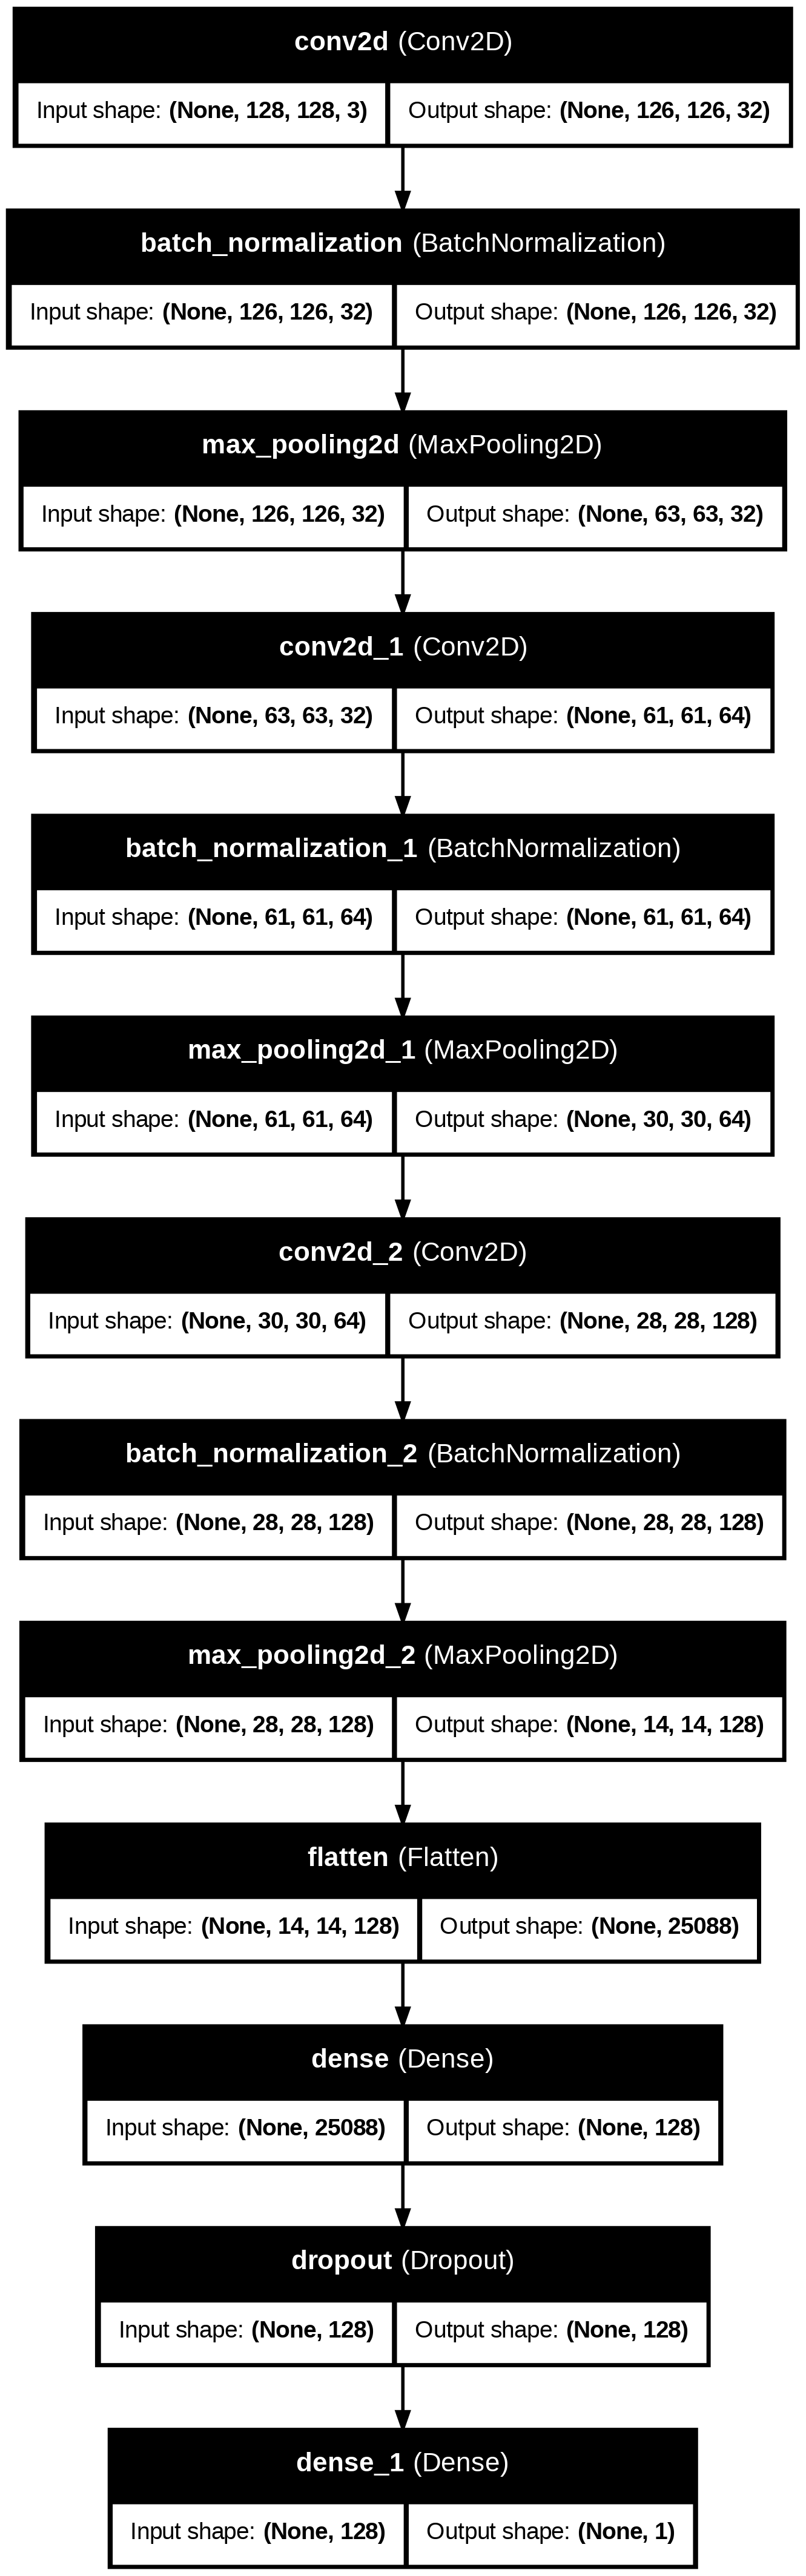

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_structure.png')


Early Stopping & Training Code

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Early stopping and best model saving
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6529 - loss: 0.6886

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


689/689 ━━━━━━━━━━━━━━━━━━━━ 1397s 2s/step - accuracy: 0.6530 - loss: 0.6884 - val_accuracy: 0.8165 - val_loss: 0.3923
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 1341s 2s/step - accuracy: 0.8643 - loss: 0.3280 - val_accuracy: 0.7475 - val_loss: 0.5288
Epoch 3/15
462/689 ━━━━━━━━━━━━━━━━━━━━ 7:02 2s/step - accuracy: 0.9098 - loss: 0.2567

Visualize Accuracy & Loss

In [ ]:
# Plot training history
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


Evaluate the Model

In [ ]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


Save Final Model

In [ ]:
model.save("final_rbc_classifier.h5")
print("Model saved successfully!")


In [ ]:
from google.colab import files
files.download("final_rbc_classifier.h5")


Import tools

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

Generate predictions

In [ ]:
# Get true labels and predictions
val_generator.reset()
pred = model.predict(val_generator, verbose=1)
pred_labels = (pred > 0.5).astype(int).ravel()  # convert probabilities to 0 or 1
true_labels = val_generator.classes

# Class names
class_names = list(val_generator.class_indices.keys())
print("Classes:", class_names)


Confusion Matrix

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


Classification Report

In [ ]:
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names))


Visualize Sample Predictions

In [ ]:
# Show some example predictions
x, y = next(val_generator)
preds = (model.predict(x) > 0.5).astype(int)

plt.figure(figsize=(12,8))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x[i])
    title = f"True: {int(y[i])} | Pred: {int(preds[i])}"
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


Grad-CAM Setup Code   Gradient-weighted Class Activation Mapping (Grad-CAM) shows where  CNN “looked” in an image when making its decision.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Grad-CAM Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradient of the top predicted class wrt the feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight feature maps by importance
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Visualization Function

In [ ]:
def display_gradcam(image_path, model, last_conv_layer_name='conv2d_2'):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0)

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Overlay on image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128,128))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM Visualization")
    plt.axis('off')
    plt.show()


Run for the heatmap overlay

In [ ]:
model = tf.keras.models.load_model("final_rbc_classifier.h5")
display_gradcam("/content/cell_images/Parasitized/C1_thinF_IMG_20150604_104722_cell_9.png", model)


Model Optimization (Edge Deployment Ready)Step 10 — Model Optimization (Edge Deployment Ready)

You already have ✅ Early Stopping + ModelCheckpoint.
Now we’ll add a short post-training optimization example.

🎯 Goal:

Make your CNN smaller and faster → deployable on embedded devices (like Raspberry Pi or hospital lab machines).

📘 Code (TensorFlow Lite Conversion)

Add this after training finishes:

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("best_model.h5")


Pruning

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {
    "pruning_schedule": tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

model_for_pruning.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])


Quantization

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("model_quantized.tflite", "wb") as f:
    f.write(tflite_model)


Check size difference

In [ ]:
import os

print("Original model size: ", os.path.getsize("best_model.h5")/1024/1024, "MB")
print("Pruned model size: ", os.path.getsize("model_pruned.h5")/1024/1024, "MB")
print("Quantized model size: ", os.path.getsize("model_quantized.tflite")/1024/1024, "MB")
